This script will discuss the current implementation of this metric (as it is currently on the txsim repo), and some points we think could be improved.

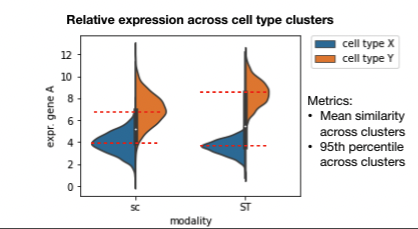

The way we interpret this metric is: 
- For a given gene A, let's say we measure the relative difference in its expression between cell type X and cell type Y in the sc modality
- How similar is this relative diff quantity to the same relative diff quantity (relative difference in expression of gene A between cell type X and cell type Y) in the sp modality?

#### import packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import issparse

#### import test data

In [2]:
## load in example datasets 
adata_sc = sc.read("/mnt/storage/adata_sc.h5ad")
adata_sp = sc.read("/mnt/storage/adata_sp.h5ad")

In [3]:
## first normalize the test adatas -- they don't have a lognorm layer yet
adata_sc.layers['raw'] = adata_sc.X
adata_sp.layers['raw'] = adata_sp.X

adata_sc.layers['norm'] = sc.pp.normalize_total(adata=adata_sc, target_sum=None, exclude_highly_expressed=False, max_fraction=0.05, key_added=None, layer=None, copy=False, inplace=False)['X']
adata_sp.layers['norm'] = sc.pp.normalize_total(adata=adata_sp, target_sum=None, exclude_highly_expressed=False, max_fraction=0.05, key_added=None, layer=None, copy=False, inplace=False)['X']

adata_sc.layers['lognorm'] = adata_sc.layers['norm'].copy()
adata_sp.layers['lognorm'] = adata_sp.layers['norm'].copy()

sc.pp.log1p(adata_sc, layer='lognorm')
sc.pp.log1p(adata_sp, layer='lognorm')

/home/ubuntu/miniconda3/envs/project-4-env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


#### below see the function as it is currently: 

In [4]:
def similar_ge_across_clusters(adata_sp: AnnData, adata_sc: AnnData, layer: str='lognorm', key='celltype'):
    """Calculate the difference between mean normalized expression of genes across lusters in both modalities
    Parameters
    ----------
    adata_sp : AnnData
        annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        annotated ``AnnData`` object with counts scRNAseq data
    pipeline_output : float, optional
        Boolean for whether to use the 
    Returns
    -------
    scores : list
       similarity value for every gene across clusters
    """   
    # Set layer to calculate the metric on
    adata_sc.X = adata_sc.layers[layer]
    adata_sp.X = adata_sp.layers[layer]
    # Get shared genes between sc and spatial data
    intersect = list(set(adata_sp.var_names).intersection(set(adata_sc.var_names)))
    # Subset sc data to spatial genes
    adata_sc=adata_sc[:,intersect]
    # Sparse matrix support
    for a in [adata_sc, adata_sp]:
        if issparse(a.X):
            a.X = a.X.toarray()
    # Get cell types that occur in both sc and spatial
    unique_celltypes=adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
        
    # Set gene expression Dataframe for scRNAseq
    exp_sc=pd.DataFrame(adata_sc.X,columns=adata_sc.var.index) # is it needed to get Dataframes
    #gene_means_sc =np.mean(adata_sc.X,axis=0) -TODO
    # Set Dataframe with the mean expression values for each gene across all the cells
    gene_means_sc=pd.DataFrame(np.mean(exp_sc,axis=0))
    # Sort 'gene_means_sc':  the gene names in ascending order
    gene_means_sc=gene_means_sc.loc[gene_means_sc.index.sort_values(),:]

    # Same process for spatial data (Gene expression Dataframe with mean expression values for each gene across all the cells)
    exp_sp=pd.DataFrame(adata_sp.X,columns=adata_sp.var.index)
    gene_means_sp=pd.DataFrame(np.mean(exp_sp,axis=0))
    gene_means_sp=gene_means_sp.loc[gene_means_sp.index.sort_values(),:]
    
    # Add a new column for 'celltype'to the gene expression Dataframes(each spatial and scRNAseq)
    exp_sc['celltype']=list(adata_sc.obs['celltype'])
    exp_sp['celltype']=list(adata_sp.obs['celltype'])
    # Subset gene expression Dataframe(for each scRNAseq and spatial data) including only the unique cell types 
    exp_sc=exp_sc.loc[exp_sc['celltype'].isin(unique_celltypes),:]
    exp_sp=exp_sp.loc[exp_sp['celltype'].isin(unique_celltypes),:]

    # Set Dataframe with corresponding mean expression value each scRNAseq and spatial 
    mean_celltype_sc=exp_sc.groupby('celltype').mean()
    mean_celltype_sc=mean_celltype_sc.loc[:,mean_celltype_sc.columns.sort_values()]
    mean_celltype_sp=exp_sp.groupby('celltype').mean()
    mean_celltype_sp=mean_celltype_sp.loc[:,mean_celltype_sp.columns.sort_values()]

    #If no read is prestent in a gene, we add 0.1 so that we can compute statistics
    mean_celltype_sp.loc[:,list(mean_celltype_sp.sum(axis=0)==0)]=0.1
    mean_celltype_sc.loc[:,list(mean_celltype_sc.sum(axis=0)==0)]=0.1

    # Set Dataframes with mean-normalized expression values for each gene
    mean_celltype_sp_norm=mean_celltype_sp.div(mean_celltype_sp.mean(axis=0),axis=1)
    mean_celltype_sc_norm=mean_celltype_sc.div(mean_celltype_sc.mean(axis=0),axis=1)

    # Create Array with mean absolute difference between the normalized gene expression values for each gene and each cell type
    values=np.mean(abs(mean_celltype_sp_norm-mean_celltype_sc_norm),axis=0)

    # Set Dataframe with one column and rows as 'values'
    scores=pd.DataFrame(values,columns=['score']).sort_values(by='score')
    return scores

### but let's run through it section by section to visualize what it is doing...

#### Here you see the preparation steps :
- set the adata.X to lognormalized counts, 
- take the subset of intersecting sc and sp genes
- get a list of unique cell types shared b/t sc and sp data

In [5]:
layer='lognorm'
key='celltype'

# Set layer to calculate the metric on
adata_sc.X = adata_sc.layers[layer]
adata_sp.X = adata_sp.layers[layer]

# Get shared genes between sc and spatial data
intersect = list(set(adata_sp.var_names).intersection(set(adata_sc.var_names)))
    
# Subset sc data to spatial genes
adata_sc=adata_sc[:,intersect]

# Sparse matrix support
for a in [adata_sc, adata_sp]:
    if issparse(a.X):
        a.X = a.X.toarray()

# Get cell types that occur in both sc and spatial
unique_celltypes=adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()

In [6]:
unique_celltypes

['Myoz2-enriched cardiomyocytes', 'Ventricular cardiomyocytes', 'Endothelium / pericytes ', 'Capillary endothelium', 'Fibroblast-like ', 'Smooth muscle cells ', 'Epicardial cells', 'Atrial cardiomyocytes', 'Cardiac neural crest cells ']
Categories (11, object): ['Atrial cardiomyocytes', 'Capillary endothelium', 'Cardiac neural crest cells ', 'Endothelium / pericytes ', ..., 'Immune cells', 'Myoz2-enriched cardiomyocytes', 'Smooth muscle cells ', 'Ventricular cardiomyocytes']

In [7]:
#### define pandas dataframes representing mean gene expression across all cells for sc and sp data

# get the adata_sc and adata_sp cell x gene matrix as a pandas dataframe (w gene names as column names)
exp_sc=pd.DataFrame(adata_sc.X,columns=adata_sc.var.index)
exp_sp=pd.DataFrame(adata_sp.X,columns=adata_sp.var.index)

#### the below steps are included in the code but don't actually end up being used for any further calculations, so we suggest to just delete it...

In [ ]:
# find the mean expression of each gene across all cells in the sc dataset
gene_means_sc=pd.DataFrame(np.mean(exp_sc,axis=0))
# sort the genes so that they're in alphabetical order in the gene_means_sc df
gene_means_sc=gene_means_sc.loc[gene_means_sc.index.sort_values(),:]
    
# same thing for adata_sp
gene_means_sp=pd.DataFrame(np.mean(exp_sp,axis=0))
gene_means_sp=gene_means_sp.loc[gene_means_sp.index.sort_values(),:]

#### now, we find the mean gene expression of each gene ~ *across cell types* ~

In [8]:
## FIND MEAN_CELLTYPE_SC and MEAN_CELLTYPE_SP
# add "celltype" label column to exp_sc & exp_sp cell x gene 
exp_sc['celltype']=list(adata_sc.obs[key])
exp_sp['celltype']=list(adata_sp.obs[key])
    
# delete all cells from the exp matrices if they aren't in the set of intersecting celltypes b/t sc & sp data
exp_sc=exp_sc.loc[exp_sc[key].isin(unique_celltypes),:]
exp_sp=exp_sp.loc[exp_sp[key].isin(unique_celltypes),:]
    
# find the mean expression for each gene for each celltype in sc and sp data
mean_celltype_sp=exp_sp.groupby(key).mean()
mean_celltype_sc=exp_sc.groupby(key).mean()
    
# sort genes in alphabetical order 
mean_celltype_sc=mean_celltype_sc.loc[:,mean_celltype_sc.columns.sort_values()]
mean_celltype_sp=mean_celltype_sp.loc[:,mean_celltype_sp.columns.sort_values()]
    

#### The result is mean log-normalized counts of each gene for each cell type:

In [9]:
mean_celltype_sc.head()

,ALDH1A1,CCDC102B,CDK1,CLDN5,CLU,COL1A1,COL1A2,COL3A1,COL9A2,COX4I2,...,TBX18,TBX5,TCF21,TM4SF18,TMEM100,TNNI1,TNNT1,TOP2A,TPM1,TRIL
celltype,,,,,,,,,,,,,,,,,,,,,
Atrial cardiomyocytes,0.070622,0.014332,0.134023,0.000000,0.173841,0.770815,0.631345,0.567033,0.011336,0.000000,...,0.315678,0.930767,0.212845,0.014428,0.014428,3.255895,0.058358,0.214871,4.437976,0.083696
Capillary endothelium,0.018484,0.008688,0.127884,0.121026,0.679183,0.848604,1.665936,3.010427,0.029125,0.053380,...,0.004407,0.012320,0.024709,0.037562,1.816919,0.409603,0.034472,0.124519,1.557335,0.013310
Cardiac neural crest cells,0.000000,0.000000,0.275400,0.000000,0.000000,0.327139,0.105324,0.226673,0.106637,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.595246,0.221815,0.412716,1.205898,0.000000
Endothelium / pericytes,0.021827,0.020329,0.277732,1.842660,0.091237,0.174514,0.617577,0.590308,0.000000,0.000000,...,0.022038,0.000000,0.016606,1.061958,0.046820,0.504329,0.000000,0.277497,1.308317,0.024577
Epicardial cells,0.020325,0.193309,0.138615,0.025699,0.298250,3.206337,2.527879,2.527611,0.087567,0.034449,...,0.497212,0.109456,1.388747,0.008125,0.047454,0.997150,0.963487,0.146544,2.759103,0.244209


In [10]:
mean_celltype_sc.min().min() # theoretically could this be a negative number? since we're doing log-norm?

0.0

In [11]:
mean_celltype_sp.head()

gene,ALDH1A1,CCDC102B,CDK1,CLDN5,CLU,COL1A1,COL1A2,COL3A1,COL9A2,COX4I2,...,TBX18,TBX5,TCF21,TM4SF18,TMEM100,TNNI1,TNNT1,TOP2A,TPM1,TRIL
celltype,,,,,,,,,,,,,,,,,,,,,
Atrial cardiomyocytes,0.000700,0.000228,0.023692,0.000000,0.000989,0.045176,0.043050,0.038946,0.001306,0.000000,...,0.032891,0.333469,0.013381,0.000000,0.000620,0.191267,0.018046,0.042375,0.156572,0.000971
Capillary endothelium,0.004967,0.005213,0.033103,0.003632,0.014876,0.243021,0.516294,1.018978,0.000000,0.007478,...,0.009170,0.015802,0.003483,0.001404,0.347616,0.085348,0.003252,0.062089,0.118452,0.001252
Cardiac neural crest cells,0.497499,0.005985,0.073982,0.000000,0.013956,0.118538,0.187696,0.094670,0.113732,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027305,0.004971,0.177134,0.031088,0.017634
Endothelium / pericytes,0.000572,0.004563,0.104292,0.042431,0.004026,0.073396,0.196431,0.161011,0.000342,0.000342,...,0.000888,0.000000,0.027607,0.023745,0.015523,0.127524,0.022845,0.193295,0.180587,0.012838
Epicardial cells,0.000613,0.014809,0.028338,0.000000,0.002496,0.513873,0.363469,0.231309,0.010279,0.000844,...,0.956902,0.135613,0.105751,0.000000,0.000000,0.092443,0.359325,0.042659,0.097369,0.089973


In [12]:
mean_celltype_sp.min().min() # theoretically could this be a negative number? since we're doing log-norm?

0.0

**Question: in this dataset, it is not the case, but in other datasets, is it possible we will have negative log-normalized counts?  see slide below (from Vlad's Newbie JC presentation):**

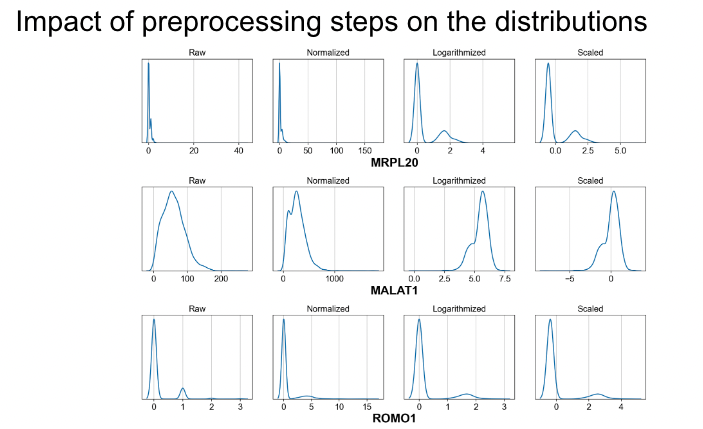

### NOW FOR THE IMPORTANT FINAL STEPS:

In [13]:
#If no read is present in a gene in any of the cell types, we add 0.1 so that we can compute statistics
mean_celltype_sp.loc[:,list(mean_celltype_sp.sum(axis=0)==0)]=0.1
mean_celltype_sc.loc[:,list(mean_celltype_sc.sum(axis=0)==0)]=0.1


**Question: does it make sense to add 0.1? This could be quite high in log-normalized expression units...**

### Now we "normalize" each gene's expression in each cell type by dividing it by the mean expression in all cell types...Asli and I are unsure if this "mean normalization" is best.

### For us, it makes a bit more sense to normalize by dividing by the sum, instead of the mean, so that all values are between 0 and 1...but perhaps there is different logic?

### But either way, does dividing gene expression per cluster by the mean expression across all cell types count as making it some "relative expression" metric?

#### ...Asli and I do not think this the best measure of "relative expression". (comparing the expression in a given cluster to its expression across all clusters)

### We think it might be better to do some more granular pairwise comparison of gene expression b/t clusters... ? Like find the pairwise differences in a given gene's expression between celltype X and celltype Y, cell type X and cell type Z, celltype Y and celltype Z, etc in the sc data and compare these relative differences to the sp data. 

#### This would be super informative, and it is nice to compute this matrix as a potential output so that users can better understand the actual biology, even if we eventually do an averaging across all pairs in the end...


In [14]:
## Divide each value in a given column by the mean of that column !!  (mean-normalization)
mean_celltype_sp_norm=mean_celltype_sp.div(mean_celltype_sp.mean(axis=0),axis=1)
mean_celltype_sc_norm=mean_celltype_sc.div(mean_celltype_sc.mean(axis=0),axis=1)


In [15]:
mean_celltype_sp_norm.head()

gene,ALDH1A1,CCDC102B,CDK1,CLDN5,CLU,COL1A1,COL1A2,COL3A1,COL9A2,COX4I2,...,TBX18,TBX5,TCF21,TM4SF18,TMEM100,TNNI1,TNNT1,TOP2A,TPM1,TRIL
celltype,,,,,,,,,,,,,,,,,,,,,
Atrial cardiomyocytes,0.011760,0.015878,0.473323,0.000000,0.160949,0.157566,0.138080,0.130917,0.064742,0.000000,...,0.255809,3.741235,0.208735,0.000000,0.015128,1.386709,0.348615,0.436204,1.075052,0.036220
Capillary endothelium,0.083390,0.362886,0.661333,0.704896,2.420321,0.847623,1.655973,3.425306,0.000000,2.922521,...,0.071321,0.177283,0.054339,0.502496,8.483462,0.618785,0.062815,0.639137,0.813312,0.046686
Cardiac neural crest cells,8.353063,0.416645,1.478001,0.000000,2.270684,0.413443,0.602020,0.318236,5.639148,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.197967,0.096034,1.823379,0.213459,0.657779
Endothelium / pericytes,0.009611,0.317613,2.083530,8.235923,0.655104,0.255994,0.630038,0.541239,0.016958,0.133671,...,0.006905,0.000000,0.430635,8.497504,0.378822,0.924569,0.441326,1.989740,1.239944,0.478907
Epicardial cells,0.010294,1.030888,0.566126,0.000000,0.406063,1.792317,1.165797,0.777547,0.509643,0.329852,...,7.442303,1.521462,1.649605,0.000000,0.000000,0.670227,6.941429,0.439125,0.668550,3.356216


In [16]:
mean_celltype_sc_norm.head()

,ALDH1A1,CCDC102B,CDK1,CLDN5,CLU,COL1A1,COL1A2,COL3A1,COL9A2,COX4I2,...,TBX18,TBX5,TCF21,TM4SF18,TMEM100,TNNI1,TNNT1,TOP2A,TPM1,TRIL
celltype,,,,,,,,,,,,,,,,,,,,,
Atrial cardiomyocytes,1.399923,0.199412,0.631607,0.000000,0.500690,0.561516,0.494417,0.394883,0.096262,0.000000,...,2.538671,4.593406,0.459825,0.114649,0.059173,1.982204,0.347678,0.924122,1.474942,0.920944
Capillary endothelium,0.366406,0.120878,0.602674,0.540087,1.956159,0.618184,1.304623,2.096467,0.247323,1.746447,...,0.035438,0.060802,0.053381,0.298466,7.451363,0.249368,0.205372,0.535534,0.517573,0.146460
Cardiac neural crest cells,0.000000,0.000000,1.297867,0.000000,0.000000,0.238311,0.082481,0.157855,0.905554,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.362389,1.321511,1.775019,0.400775,0.000000
Endothelium / pericytes,0.432669,0.282859,1.308859,8.222971,0.262777,0.127128,0.483635,0.411091,0.000000,0.000000,...,0.177232,0.000000,0.035874,8.438350,0.192012,0.307038,0.000000,1.193466,0.434813,0.270429
Epicardial cells,0.402900,2.689672,0.653247,0.114682,0.859008,2.335724,1.979625,1.760233,0.743611,1.127096,...,3.998565,0.540172,3.000215,0.064561,0.194612,0.607070,5.740187,0.630259,0.916976,2.687129


In [17]:
# Create array with mean absolute difference between the normalized gene expression values for each gene and each cell type
values=np.mean(abs(mean_celltype_sp_norm-mean_celltype_sc_norm),axis=0)

# Set dataframe with one column and rows as 'values'
scores=pd.DataFrame(values,columns=['score']).sort_values(by='score')

In [18]:
values

gene
ALDH1A1     1.856236
CCDC102B    0.459568
CDK1        0.309264
CLDN5       0.052654
CLU         0.718873
              ...   
TNNI1       0.312683
TNNT1       0.468869
TOP2A       0.302438
TPM1        0.338451
TRIL        0.368353
Length: 66, dtype: float64

In [19]:
scores #just the same as values, but reordered from lowest to highest

,score
gene,
CLDN5,0.052654
TM4SF18,0.058485
LDB3,0.183406
GJA4,0.212862
FABP3,0.217575
...,...
ISL1,1.819959
ALDH1A1,1.856236
PCSK1N,1.957220


In [20]:
scores.min()

score    0.052654
dtype: float64

In [21]:
scores.max()

score    1.968518
dtype: float64

Scores could be normalized in the end to be between 0 and 1, would make it more interpretable maybe?

#### Overall, I think we could maybe improve this metric to capture more information...(like what the actual source of the differences in gene expression b/t cell types is -- which cell types are contributing most to the discrepancy b/t sc and sp???) 

#### We (Katelyn and Asli) have come up with some idea of how to implement this but nice to discuss further.